# 8. Artificial (Reber) Grammar validator using RNNs

_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

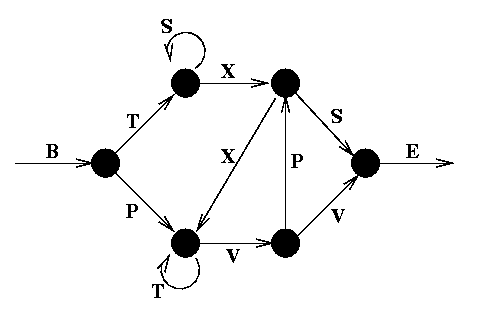

## Prepare environment

In [49]:
import random

import unittest

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras

import matplotlib.pyplot as plt

## Prepare dataset

### Create function to generate Reber grammar text

In [2]:
class ReberGrammarV1:
    grammar_rules = {
        "BT" : ["S", "X"],
        "TS" : ["S", "X"],
        "TX" : ["X", "S"],
        "SS" : ["S", "X"],
        "SX" : ["X", "S"],
        "XX" : ["T", "V"],
        "XT" : ["T", "V"],
        "XV" : ["P", "V"],
        "XS" : ["E"],
        "BP" : ["T", "V"],
        "PT" : ["T", "V"],
        "TT" : ["T", "V"],
        "PV" : ["P", "V"],
        "TV" : ["P", "V"],
        "VV" : ["E"],
        "VP" : ["X", "S"],
        "PS" : ["E"],
        "PX" : ["T", "V"]
    }

    def create_new_text(self):
        # First char
        result = "B"

        # Second char
        result += random.choice(["T", "P"])

        while True:
            last_two_chars = result[-2:]
            next_options = self.grammar_rules.get(last_two_chars)
            if (next_options == None):
                raise Exception(f"Invalid sequence {last_two_chars}")
            next_char = random.choice(next_options)
            result += next_char
            if (next_char == "E"):
                break
        
        return result
    
    def verify(self, text):
        if len(text) < 5:
            raise Exception(f"{text} isn't at least 5 chars long")
        if text[0] != "B":
            raise Exception(f"{text} doesn't start with B")
        if text[1] != "T" and text[1] != "P":
            raise Exception(f"{text} doesn't have T or P as it's second char")
        if text[-1] != "E":
            raise Exception(f"{text} doesn't end with E")
        for index in range(2, len(text)):
            char = text[index]
            two_chars_before = text[index-2:index]
            if (char not in self.grammar_rules.get(two_chars_before)):
                raise Exception(f"{text} is invalid: {char} cannot follow {two_chars_before}")


In [3]:
class ReberGrammarV2:
    grammar_rules = {
        0 : [(1, "B")],
        1 : [(2, "T"), (3, "P")],
        2 : [(2, "S"), (4, "X")],
        3 : [(3, "T"), (5, "V")],
        4 : [(3, "X"), (6, "S")],
        5 : [(4, "P"), (6, "V")],
        6 : [(7, "E")]
    }

    def create_new_text(self):
        result = ""
        state = 0
        while True:
            next_options = self.grammar_rules.get(state)
            if (next_options == None):
                raise Exception(f"Invalid state {state}")
            next_state, next_char = random.choice(next_options)

            result += next_char

            state = next_state
            if (state == 7):
                break
        return result
    
    def verify(self, text):
        if len(text) < 5:
            raise Exception(f"{text} isn't at least 5 chars long")

        state = 0
        for index in range(0, len(text)):
            char = text[index]
            valid = False
            for next_state, next_char in self.grammar_rules.get(state):
                if (char == next_char):
                    state = next_state
                    valid = True
            if not valid:
                raise Exception(f"{text} is not valid: {char} is not a valid option for state {state}")

In [4]:
class TestReberGrammar():

    def test_fail_1(self):
        self.assertRaises(Exception, self.grammar.verify, "BTSSPXSE")
    
    def test_fail_2(self):
        self.assertRaises(Exception, self.grammar.verify, "BPTVVB")
    
    def test_fail_3(self):
        self.assertRaises(Exception, self.grammar.verify, "BTXXVVSE")

    def test_fail_4(self):
        self.assertRaises(Exception, self.grammar.verify, "BPVSPSE")

    def test_fail_5(self):
        self.assertRaises(Exception, self.grammar.verify, "BTSSSE")
    
    def test_fail_6(self):
        self.assertRaises(Exception, self.grammar.verify, "B")

    def test_success_1(self):
        self.grammar.verify("BTSSXXTVVE")

    def test_success_2(self):
        self.grammar.verify("BPVVE")

    def test_success_3(self):
        self.grammar.verify("BTXXVPSE")

    def test_success_4(self):
        self.grammar.verify("BPVPXVPXVPXVVE")

    def test_success_5(self):
        self.grammar.verify("BTSXXVPSE")

In [5]:
class TestReberGrammarV1(unittest.TestCase, TestReberGrammar):
    def setUp(self):
        self.grammar = ReberGrammarV1()

In [6]:
class TestReberGrammarV2(unittest.TestCase, TestReberGrammar):
    def setUp(self):
        self.grammar = ReberGrammarV2()

In [7]:
grammar = ReberGrammarV1()
new_text = grammar.create_new_text()
grammar.verify(new_text)
print(new_text)

BPVPSE


In [8]:
grammar = ReberGrammarV2()
new_text = grammar.create_new_text()
grammar.verify(new_text)
print(new_text)

BPTTTVVE


In [9]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_fail_1 (__main__.TestReberGrammarV1.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV1.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV1.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV1.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV1.test_fail_5) ... ok
test_fail_6 (__main__.TestReberGrammarV1.test_fail_6) ... ok
test_success_1 (__main__.TestReberGrammarV1.test_success_1) ... ok
test_success_2 (__main__.TestReberGrammarV1.test_success_2) ... ok
test_success_3 (__main__.TestReberGrammarV1.test_success_3) ... ok
test_success_4 (__main__.TestReberGrammarV1.test_success_4) ... ok
test_success_5 (__main__.TestReberGrammarV1.test_success_5) ... ok
test_fail_1 (__main__.TestReberGrammarV2.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV2.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV2.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV2.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV2.test_fail_5) .

In [ ]:
vocabulary = "BTPSXVE"

def generate_incorrect_sample_old(reber_grammar, max_length):
    while True:
        incorrect_text = "".join(
            random.choices(vocabulary, k=random.randint(1, max_length))
        )
        try:
            reber_grammar.verify(incorrect_text)
            continue
        except Exception as e:
            return incorrect_text

In [ ]:
# change only one char so that it is more difficult to differentiate between valid and invalid samples
def generate_incorrect_sample(reber_grammar):
    while True:
        incorrect_text = reber_grammar.create_new_text()
        index_to_change = random.randint(0, len(incorrect_text) - 1)
        char_to_replace = random.choice(vocabulary)
        incorrect_text = (
            incorrect_text[:index_to_change] + char_to_replace + incorrect_text[index_to_change + 1:]
        )
        try:
            reber_grammar.verify(incorrect_text)
            continue
        except Exception as e:
            return incorrect_text

In [211]:
reber_grammar = ReberGrammarV1()
generate_incorrect_sample(reber_grammar, 20)

'BPTVPE'

### Generate dataset
50% valid and 50% invalid

In [ ]:
num_of_samples = 1000

In [ ]:
reber_grammar = ReberGrammarV1()
correct_samples = [reber_grammar.create_new_text() for _ in range(num_of_samples // 2)]
incorrect_samples = [generate_incorrect_sample(reber_grammar) for _ in range(num_of_samples // 2)]

In [213]:
correct_samples = [(sample, 1) for sample in correct_samples]
incorrect_samples = [(sample, 0) for sample in incorrect_samples]

In [214]:
all_samples = correct_samples + incorrect_samples

In [215]:
train_samples, test_samples = train_test_split(all_samples, test_size=0.2, shuffle=True)
valid_samples, test_samples = train_test_split(test_samples, test_size=0.5, shuffle=True)

In [216]:
print(len(train_samples))
print(len(valid_samples))
print(len(test_samples))

800
100
100


In [217]:
train_samples[:10]

[('BTSXSE', 1),
 ('BPSSXXVPXVVE', 0),
 ('BTXXE', 0),
 ('BPVVE', 1),
 ('VTSSXXTTVVE', 0),
 ('BPVPTVVE', 0),
 ('BTSTSE', 0),
 ('BTXSE', 1),
 ('BTXSE', 1),
 ('BPTVPSE', 1)]

In [218]:
batch_size = 1 #32

train_ds = (
    tf.data.Dataset.from_tensor_slices(
        ([X for X, _ in train_samples], [y for _, y in train_samples])
    )
    .batch(batch_size)
    .cache()
    .prefetch(1)
)
valid_ds = (
    tf.data.Dataset.from_tensor_slices(
        ([X for X, _ in valid_samples], [y for _, y in valid_samples])
    )
    .batch(batch_size)
    .cache()
    .prefetch(1)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices(
        ([X for X, _ in test_samples], [y for _, y in test_samples])
    )
    .batch(batch_size)
    .cache()
    .prefetch(1)
)

In [219]:
for text_batch, label_batch in test_ds.take(5):
    for text, label in zip(text_batch, label_batch):
        print(text)
        print(label)

tf.Tensor(b'BTSSXXVPXTVVE', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(b'BBVVE', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'BPSPSE', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'BTSSSVXSE', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'BPTTTPXTVPXTVPSE', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


2025-03-20 23:58:23.123935: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Train RNN to classify correct Reber grammar

In [220]:
max_features = len(vocabulary)

vectorize_layer = keras.layers.TextVectorization(
    split="character", standardize="lower"
)

text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [221]:
n_tokens = vectorize_layer.vocabulary_size() - 2  # number of distinct chars = 39
n_tokens

7

In [222]:
embedding_dim = 2

# Used with batches
inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')

x = vectorize_layer(inputs)
x = keras.layers.Lambda(lambda X: X - 2)(x)  # no <PAD> or <UNK> tokens
x = keras.layers.Embedding(max_features + 1, embedding_dim)(x)
# x = keras.layers.Dropout(0.5)(x)

# Text Classification from scratch (https://keras.io/examples/nlp/text_classification_from_scratch/)
# x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = keras.layers.GlobalMaxPooling1D()(x)

# x = keras.layers.Dense(128, activation="relu")(x)
# x = keras.layers.Dropout(0.5)(x)

# charRNN
# x = keras.layers.GRU(128)(x)

x = keras.layers.SimpleRNN(16)(x)

predictions = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [223]:
epochs = 5 # 100

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Fit the model using the train and test datasets.
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[early_stopping_cb])

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.4663 - loss: 0.6972 - val_accuracy: 0.5100 - val_loss: 0.6967
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.5345 - loss: 0.6891 - val_accuracy: 0.4900 - val_loss: 0.7038
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5428 - loss: 0.6883 - val_accuracy: 0.5500 - val_loss: 0.6985
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5706 - loss: 0.6901 - val_accuracy: 0.5300 - val_loss: 0.7088
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.5867 - loss: 0.6754 - val_accuracy: 0.5500 - val_loss: 0.7027


Best epoch is: 1


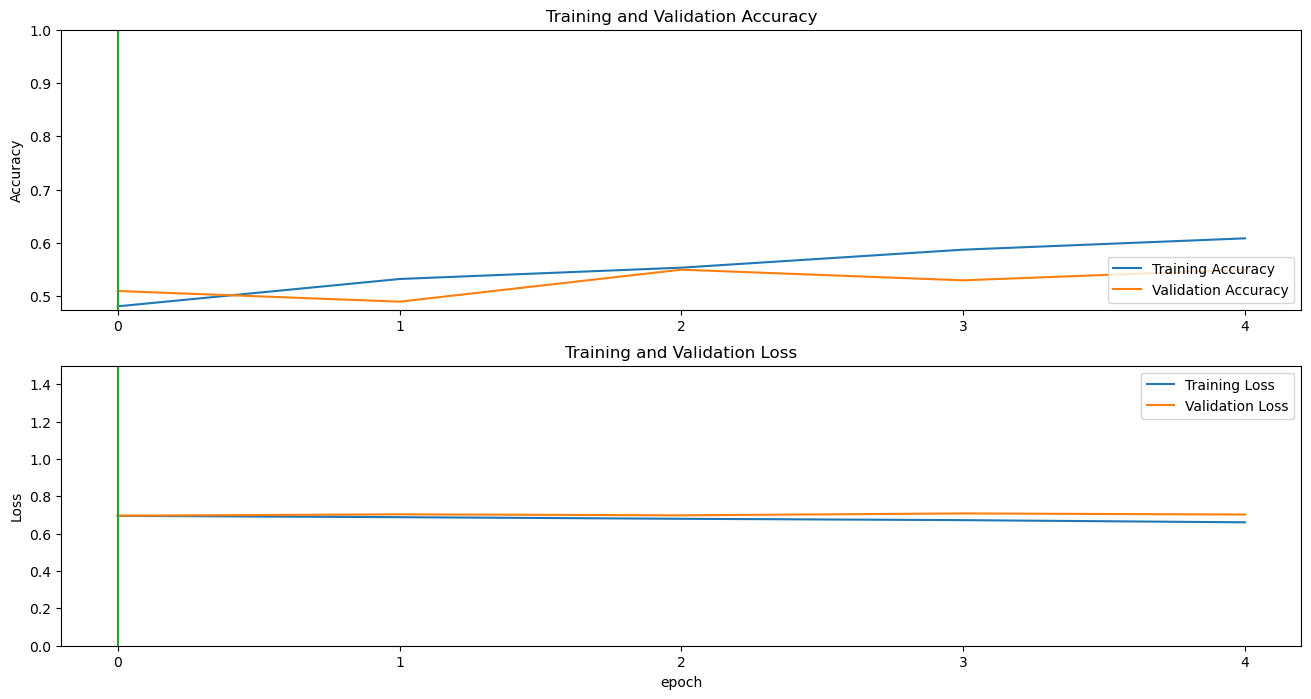

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4442 - loss: 0.7002

Test Accuracy is 0.5299999713897705 with 0.6938872337341309 loss.


In [224]:
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

best_epoch = early_stopping_cb.best_epoch + 1
print(f"Best epoch is: {best_epoch}")

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(100))
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([best_epoch-1,best_epoch-1],
        plt.ylim(), label='Best weights')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(range(100))
plt.ylabel('Loss')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.plot([best_epoch-1,best_epoch-1],
        plt.ylim(), label='Best weights')
plt.show()

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy is {test_accuracy} with {test_loss} loss.")

In [225]:
temp1 = tf.constant(["BTSSXSE"])
temp2 = tf.data.Dataset.from_tensor_slices(
    ["BTSSXSE", "BPTVVE", "BPVVE", "XBPPEXVB", "BTXSE"]
).batch(1)

# These were supposed to be all invalid, but were misclassified (it might be that the invalid training set was too different from valid
# and model could not learn actual grammar - it was enough to learn simpler heuristics)
temp3 = tf.data.Dataset.from_tensor_slices(
    ["BTSSPXSE", "BPTVVB", "BTXXVVSE", "BPVSPSE", "BTSSSE", "B"]
).batch(1)

test_dataset_no_labels = test_ds.map(lambda X, y: X)

result = model.predict(temp3)
print(result)

# TODO: why result is array of arrays?
# TODO: why there are different results if I pass one vs. many text samples
# TODO: can batch size affect how we can ask predictions? e.g. 32 batch size requires 32 batch size querries

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.5193949 ]
 [0.5206855 ]
 [0.5251604 ]
 [0.49096695]
 [0.5173092 ]
 [0.50398046]]


In [226]:
class ReberGrammarRNN():
    def verify(self, text):
        result = model.predict(tf.constant([text]))[-1][-1]
        if result < 0.5:
            raise Exception(f"{text} is not valid") 

In [227]:
class TestReberGrammarRNN(unittest.TestCase, TestReberGrammar):
    def setUp(self):
        self.grammar = ReberGrammarRNN()

In [228]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_fail_1 (__main__.TestReberGrammarRNN.test_fail_1) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/home/martin/miniconda/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
FAIL
test_fail_2 (__main__.TestReberGrammarRNN.test_fail_2) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


FAIL
test_fail_3 (__main__.TestReberGrammarRNN.test_fail_3) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


FAIL
test_fail_4 (__main__.TestReberGrammarRNN.test_fail_4) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


ok
test_fail_5 (__main__.TestReberGrammarRNN.test_fail_5) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


FAIL
test_fail_6 (__main__.TestReberGrammarRNN.test_fail_6) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


FAIL
test_success_1 (__main__.TestReberGrammarRNN.test_success_1) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


ok
test_success_2 (__main__.TestReberGrammarRNN.test_success_2) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


ok
test_success_3 (__main__.TestReberGrammarRNN.test_success_3) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


ok
test_success_4 (__main__.TestReberGrammarRNN.test_success_4) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


ok
test_success_5 (__main__.TestReberGrammarRNN.test_success_5) ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


ok
test_fail_1 (__main__.TestReberGrammarV1.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV1.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV1.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV1.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV1.test_fail_5) ... ok
test_fail_6 (__main__.TestReberGrammarV1.test_fail_6) ... ok
test_success_1 (__main__.TestReberGrammarV1.test_success_1) ... ok
test_success_2 (__main__.TestReberGrammarV1.test_success_2) ... ok
test_success_3 (__main__.TestReberGrammarV1.test_success_3) ... ok
test_success_4 (__main__.TestReberGrammarV1.test_success_4) ... ok
test_success_5 (__main__.TestReberGrammarV1.test_success_5) ... ok
test_fail_1 (__main__.TestReberGrammarV2.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV2.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV2.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV2.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV2.test_fail_5

> **IMPORTANT!** Batch size for RNNs define length of sequence.

That means that if I teach model to expect certain sequences (in our case sequence of words in Reber grammar) it will expect certain words and size of sequence (batch). In this case if I provide less words in sequence (even if the same start of the sequence) it will provide different results (probabilities).

We either need to work with batch size of 1 or use sequence of characters from single word as a batch (in which case it would probably be good idea to use padding to achieve the same sequence length - but also make sure model ignores padding and doesn't expect it during evaluation).

> **IMPORTANT!** Initial invalid samples were too different from valid and model couldn't classify correctly simple transgressions

Now we generate valid word and change just one character which is way better training and test set.

However, model is unable to learn and probabilities stay around 0.5.


TODO: try character based sequences 